#### **모두를 위한 딥러닝**
slide
https://drive.google.com/drive/folders/1qVcF8-tx9LexdDT-IY6qOnHc8ekDoL03

git
https://github.com/deeplearningzerotoall/PyTorch?tab=readme-ov-file

youtube
https://www.youtube.com/watch?v=7eldOrjQVi0&list=PLQ28Nx3M4JrhkqBVIXg-i5_CVVoS1UzAv


---

### **torchvision.datasets 주요 데이터 로드 방식 비교**

| 구분 | 대표 예시 | 용도 |
| :--- | :--- | :--- |
| **내장 데이터셋** | `dsets.MNIST`, `dsets.CIFAR10` | 학습/연구용 표준 데이터를 서버에서 직접 다운로드 |
| **ImageFolder** | `dsets.ImageFolder` | 로컬에 클래스별 폴더로 분류된 이미지 데이터를 로드 |
| **DatasetFolder** | `dsets.DatasetFolder` | 이미지 외에 다양한 확장자(텍스트, 음성 등) 파일을 로드 |

```python
import torch
import torchvision.datasets as dsets

---
### **nn.Conv2d**
- Pytorch nn.Conv2d
- input 
    - type : torch.Tensor
    - shape :( N x C x H x W )
                **(Batch_size, channel, height, width)**
```python
# pytorch 표현.
nn.Conv2d(input channel 수, 출력 채널 수(filter 수), kernel의 크기)

nn.Conv2d(1,1,3)  
# 1채널이미지(grayscale), 1개 filter, 3by3 kernel

```

**Pooling**

- max pooling
    - 커널사이즈내의 가장 큰 값 출력
- average pooling
    - 커널사이즈 내 평균 출력


---

**Mnist에 CNN 적용**

- 1. 라이브러리 가져오기
- 2. gpu 사용 설정하기
- 3. parameter 설정
- 4. 데이터셋 가져오고 dataloader 만들기
- 5. 학습모델 만들기 (CNN)
- 6. Loss function (Criterion), optimizer 선택
- 7. train 및 loss 체크
- 8. 성능 확인

In [6]:
# 1~4
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init
torch.manual_seed(777)  # for reproducibility

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    torch.cuda.manual_seed_all(777)
print(device)

# parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100

# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

# dataset loader
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)



cpu


In [ ]:
# 5. CNN Model (2 conv layers) - simple version
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # L1 ImgIn shape=(batch size: ?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            # 1 channel, 출력 채널수 32, 3x3 kernel의 conv layer
            # padding=1덕분에 28x28사이즈를 그대로 유지함 (즉 28x28짜리가 32채널)
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            # kernel size = stride는 겹치는 부분없이 pooling하겠단 뜻
            # 정확히 절반으로 줄어드는 효과
            torch.nn.MaxPool2d(kernel_size=2, stride=2)) 
        

        # L2 ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            # 입력채널 32, output channel 64, 3x3 conv layer
            #padding 덕분에 14x14사이즈 유지함 (즉, 14x14가 64개)
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            # 반토막나서 7x7이 64개
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        

        # Final FC 7x7x64 inputs -> 10 outputs
        self.fc = torch.nn.Linear(7 * 7 * 64, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc(out)
        return out

# instantiate CNN model
model = CNN().to(device)

In [28]:
# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [29]:
# train my model
total_batch = len(data_loader)
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader:
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

print('Learning Finished!')

Learning started. It takes sometime.
[Epoch:    1] cost = 0.17821233
[Epoch:    2] cost = 0.0483967997
[Epoch:    3] cost = 0.0348931924
[Epoch:    4] cost = 0.0271249656
[Epoch:    5] cost = 0.021402875
[Epoch:    6] cost = 0.0175111648
[Epoch:    7] cost = 0.0163230561
[Epoch:    8] cost = 0.0127349272
[Epoch:    9] cost = 0.0122389169
[Epoch:   10] cost = 0.0103073018
[Epoch:   11] cost = 0.00769569073
[Epoch:   12] cost = 0.00884540658
[Epoch:   13] cost = 0.00871035829
[Epoch:   14] cost = 0.00769645674
[Epoch:   15] cost = 0.00870557595
Learning Finished!


In [13]:
# Test model and check accuracy
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

Accuracy: 0.9872000217437744


---

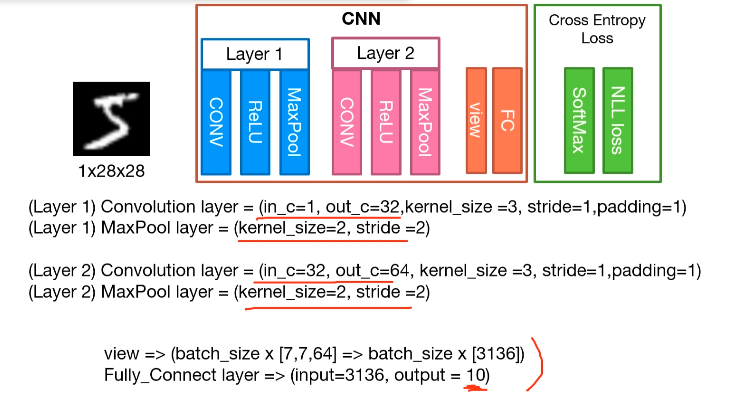

In [24]:
from IPython.display import Image, display
display(Image(filename='Pasted image.png', embed=True))

### **layer 1, 2까지가 위에 버전**
---
### **아래는 layer 3, 4,5를 추가한 버전**

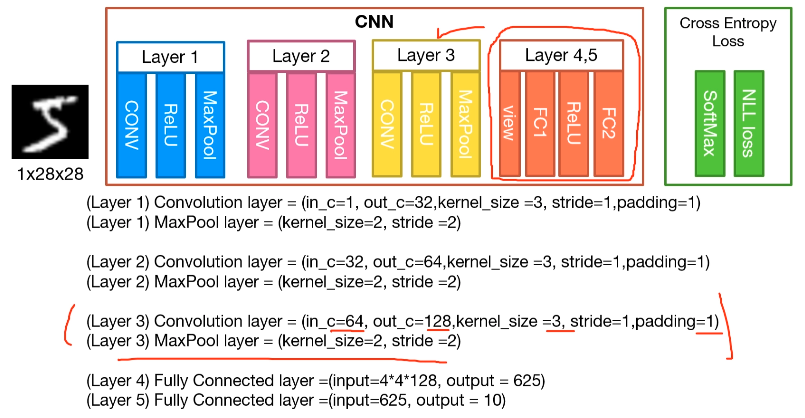

In [23]:
from IPython.display import Image, display
display(Image(filename='4.png', embed=True))

In [25]:
# CNN Model (5 layer ver) CNN + FC
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob = 0.5
        # L1 ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # L2 ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # L3 ImgIn shape=(?, 7, 7, 64)
        #    Conv      ->(?, 7, 7, 128)
        #    Pool      ->(?, 4, 4, 128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))

        # L4 FC 4x4x128 inputs -> 625 outputs
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - self.keep_prob))
        # L5 Final FC 625 inputs -> 10 outputs
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.layer4(out)
        out = self.fc2(out)
        return out

In [26]:
# 모델을 새로만들고 나서는 아래 방법을 통해 모델을 테스트 해봐야한다.
model = CNN().to(device)

value = torch.Tensor(1,1,28,28)

print((model(value)).shape)

torch.Size([1, 10])
